<a href="https://colab.research.google.com/github/Panchagiri-vidyasri/data-analysis-using-python_2116/blob/main/daup_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kinguistics/heartbeat-sounds")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kinguistics/heartbeat-sounds/versions/1


In [45]:
import os

# Path to the dataset directory
dataset_path = "/root/.cache/kagglehub/datasets/kinguistics/heartbeat-sounds/versions/1"

# List the files in the dataset directory
files_in_directory = os.listdir(dataset_path)
print(files_in_directory)

['set_b.csv', 'set_b', 'set_a', 'set_a_timing.csv', 'set_a.csv']


In [46]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [47]:
dataset_path = "/root/.cache/kagglehub/datasets/kinguistics/heartbeat-sounds/versions/1"

In [48]:
heartbeat_dirs = os.listdir(dataset_path)

In [49]:
input_folder = "/root/.cache/kagglehub/datasets/kinguistics/heartbeat-sounds/versions/1"  # Change path
output_folder = "/content/drive/MyDrive/dataset_balanced"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for file in os.listdir(input_folder):
    if file.endswith(".wav"):
        file_path = os.path.join(input_folder, file)
        audio, sr = librosa.load(file_path, sr=None)

        # Add noise
        noisy_audio = add_noise(audio)

        # Save the new audio file
        output_path = os.path.join(output_folder, "noisy_" + file)
        sf.write(output_path, noisy_audio, sr)

print("Dataset augmentation complete!")

Dataset augmentation complete!


In [50]:
features = []
labels = []

# Extract features for heartbeat sounds and labels
for heartbeat_type in heartbeat_dirs:
    heartbeat_folder_path = os.path.join(dataset_path, heartbeat_type)

    if os.path.isdir(heartbeat_folder_path):
        audio_files_in_dir = os.listdir(heartbeat_folder_path)

        for audio_file in audio_files_in_dir:
            if audio_file.endswith('.wav'):
                audio_file_path = os.path.join(heartbeat_folder_path, audio_file)

                # Load the audio file
                audio, sr = librosa.load(audio_file_path, sr=None)

                # Extract MFCC features (without taking the mean)
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

                # Append the MFCC features and corresponding labels (heartbeat_type as label)
                features.append(mfcc)
                labels.append(heartbeat_type)


In [51]:
# Convert labels to standard Python strings (if needed)
labels = [str(label) for label in labels]

# Pad MFCC features to have the same length
max_len = max(feature.shape[1] for feature in features)  # Find the maximum length
features_padded = [np.pad(feature, ((0, 0), (0, max_len - feature.shape[1])), mode='constant') for feature in features]

# Convert features and labels to numpy arrays
features = np.array(features_padded)  # Use the padded features
labels = np.array(labels)

# Check class distribution
class_distribution = Counter(labels)
print("Class Distribution:", class_distribution)

Class Distribution: Counter({np.str_('set_b'): 656, np.str_('set_a'): 176})


In [52]:
# ... (previous code for feature extraction and padding)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming 'features' and 'labels' are your data and target variables
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)  # Adjust test_size and random_state as needed

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


# Reshape data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))  # Reshape for LSTM
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # Reshape for LSTM

print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# ... (rest of your code for model building and training)

Train data shape: (665, 13, 776)
Test data shape: (167, 13, 776)


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Build the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=128, activation='relu', return_sequences=True))  # Added return_sequences=True
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(units=128, activation='relu'))  # No need for return_sequences as it's the last LSTM layer
model.add(Dropout(0.2))

# Dense output layer with softmax activation (since it's multi-class classification)
# Get the number of unique labels
num_classes = len(np.unique(y_train))  # Use y_train to get unique labels

# Replace labels_encoded with num_classes
model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                       │ (None, 13, 128)             │         463,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 13, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 726,786 (2.77 MB)

 Trainable params: 726,786 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.5982 - loss: 15.5398 - val_accuracy: 0.9401 - val_loss: 4.3082
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.8888 - loss: 15.2224 - val_accuracy: 0.8922 - val_loss: 12.2535
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.8359 - loss: 8.7958 - val_accuracy: 0.8383 - val_loss: 7.2652
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.7483 - loss: 17.5790 - val_accuracy: 0.6407 - val_loss: 11.8695
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6450 - loss: 16.0142 - val_accuracy: 0.6587 - val_loss: 16.6338
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.6530 - loss: 18.7666 - val_accuracy: 0.8024 - val_loss: 10.6038
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.6864 - loss: 13.6455 - val_accuracy: 0.7246 - val_loss: 7.7474
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.6846 - loss: 11.2792 - val_

In [39]:
import tensorflow as tf
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9307 - loss: 1.0260
Test Loss: 1.265741229057312
Test Accuracy: 0.916167676448822


In [40]:
# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Convert label_encoder.classes_ to a list of strings
target_names = [str(cls) for cls in label_encoder.classes_]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names)) # Use target_names instead of label_encoder.classes_

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
Classification Report:
              precision    recall  f1-score   support

       set_a       0.80      0.91      0.85        43
       set_b       0.97      0.92      0.94       124

    accuracy                           0.92       167
   macro avg       0.88      0.91      0.89       167
weighted avg       0.92      0.92      0.92       167



Confusion Matrix:


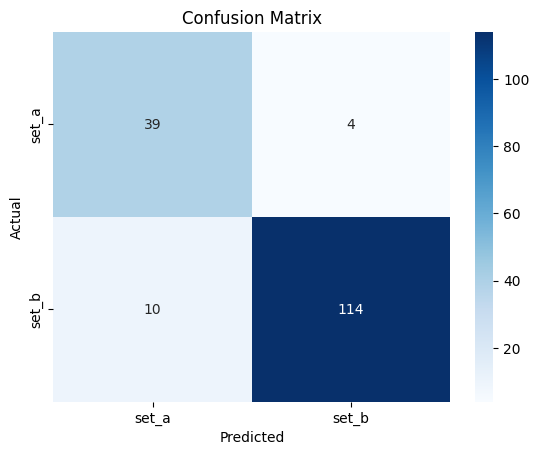

In [41]:
# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

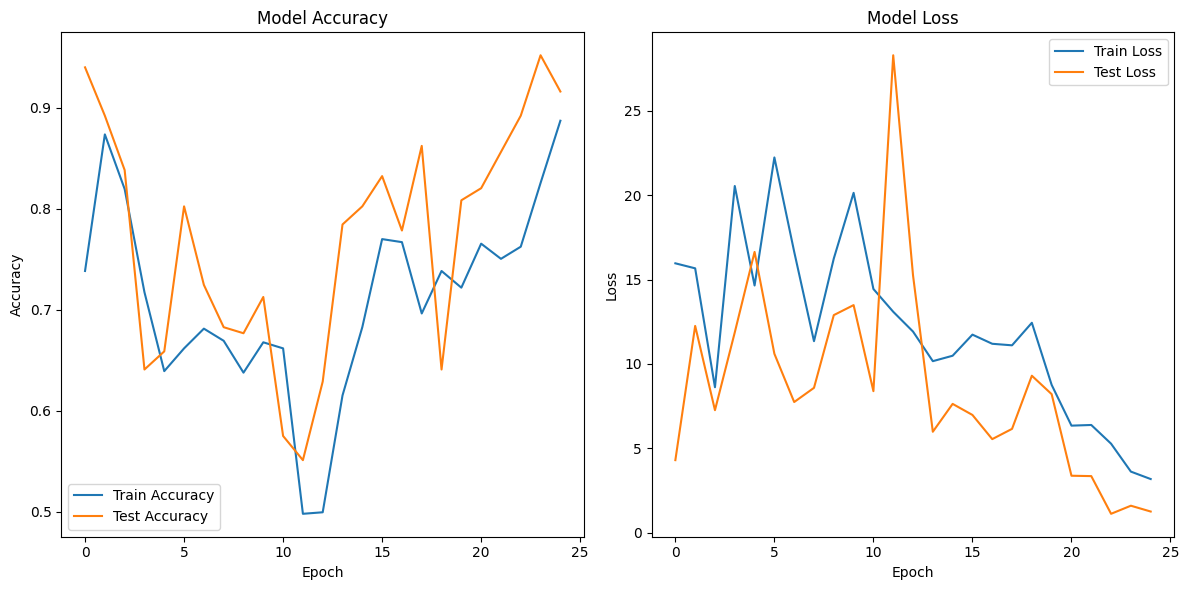

In [42]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [43]:
# Z-Test
from statsmodels.stats.weightstats import ztest
from scipy.stats import ttest_ind
from scipy.stats import ttest_ind, f_oneway
sample1 = np.random.normal(50, 10, 100)
sample2 = np.random.normal(52, 10, 100)
z_stat, p_value = ztest(sample1, sample2)
print(f"Z-Test: Z-stat = {z_stat:.2f}, p-value = {p_value:.4f}")

# T-Test
t_stat, p_ttest = ttest_ind(sample1, sample2)
print(f"T-Test: T-stat = {t_stat:.2f}, p-value = {p_ttest:.4f}")

# ANOVA Test
sample3 = np.random.normal(48, 10, 100)
anova_stat, p_anova = f_oneway(sample1, sample2, sample3)
print(f"ANOVA Test: F-stat = {anova_stat:.2f}, p-value = {p_anova:.4f}")



Z-Test: Z-stat = -0.67, p-value = 0.5028
T-Test: T-stat = -0.67, p-value = 0.5035
ANOVA Test: F-stat = 6.03, p-value = 0.0027
